<a href="https://colab.research.google.com/github/LarshVakil/Semantic-Search-Engine/blob/main/FinalIPLPredicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle

df = pd.read_csv('IPL.csv')

print(f'shape is {df.shape}')
df.head()

/tmp/ipython-input-3347641699.py:12: DtypeWarning: Columns (28,29,30,31,43,46,47,48,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('IPL.csv')


shape is (278205, 64)


,Unnamed: 0,match_id,date,match_type,event_name,innings,batting_team,bowling_team,over,ball,...,team_runs,team_balls,team_wicket,new_batter,batter_runs,batter_balls,bowler_wicket,batting_partners,next_batter,striker_out
0,131970,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,...,1,1,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
1,131971,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,...,1,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
2,131972,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,...,2,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
3,131973,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,...,2,3,0,NaN,0,2,0,"('BB McCullum', 'SC Ganguly')",NaN,False
4,131974,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,...,2,4,0,NaN,0,3,0,"('BB McCullum', 'SC Ganguly')",NaN,False


In [76]:
#Current teams
teams = [
    'Chennai Super Kings', 'Delhi Capitals', 'Gujarat Titans',
    'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians',
    'Punjab Kings', 'Rajasthan Royals', 'Royal Challengers Bengaluru',
    'Sunrisers Hyderabad'
]

#Same teams but have new names
df['batting_team'] = df['batting_team'].str.replace('Delhi Daredevils', 'Delhi Capitals')
df['bowling_team'] = df['bowling_team'].str.replace('Delhi Daredevils', 'Delhi Capitals')

df['batting_team'] = df['batting_team'].str.replace('Kings XI Punjab', 'Punjab Kings')
df['bowling_team'] = df['bowling_team'].str.replace('Kings XI Punjab', 'Punjab Kings')

df['batting_team'] = df['batting_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
df['bowling_team'] = df['bowling_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

df['batting_team'] = df['batting_team'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')
df['bowling_team'] = df['bowling_team'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')

#Include only current teams removing old teams like pune and kochi
df = df[df['batting_team'].isin(teams)]
df = df[df['bowling_team'].isin(teams)]

#DLS (Duckworth - Lewis System) is for rain atches with reduced overs and complcated formulae so removing them
if 'method' in df.columns:
    df = df[df['method'] != 'D/L']
df.head()
print(f"Data remaining {df.shape}")

print(df.columns)

Data remaining (248023, 64)
Index(['Unnamed: 0', 'match_id', 'date', 'match_type', 'event_name', 'innings',
       'batting_team', 'bowling_team', 'over', 'ball', 'ball_no', 'batter',
       'bat_pos', 'runs_batter', 'balls_faced', 'bowler', 'valid_ball',
       'runs_extras', 'runs_total', 'runs_bowler', 'runs_not_boundary',
       'extra_type', 'non_striker', 'non_striker_pos', 'wicket_kind',
       'player_out', 'fielders', 'runs_target', 'review_batter',
       'team_reviewed', 'review_decision', 'umpire', 'umpires_call',
       'player_of_match', 'match_won_by', 'win_outcome', 'toss_winner',
       'toss_decision', 'venue', 'city', 'day', 'month', 'year', 'season',
       'gender', 'team_type', 'superover_winner', 'result_type', 'method',
       'balls_per_over', 'overs', 'event_match_no', 'stage', 'match_number',
       'team_runs', 'team_balls', 'team_wicket', 'new_batter', 'batter_runs',
       'batter_balls', 'bowler_wicket', 'batting_partners', 'next_batter',
       'striker_

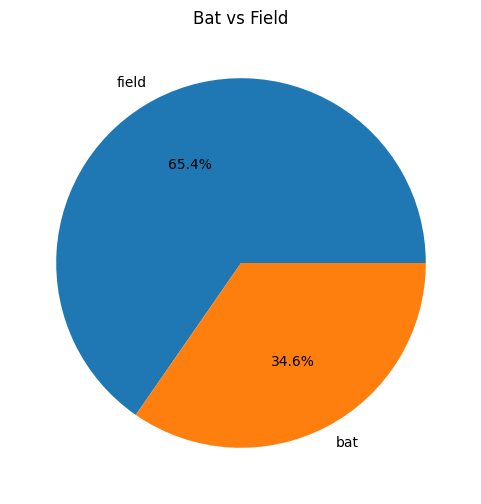

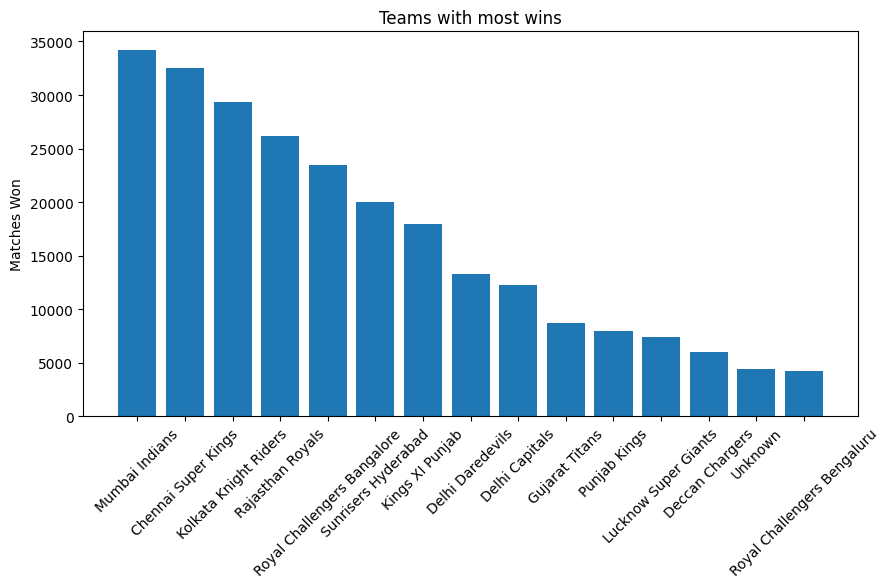

In [77]:
#Toss selection on winning
toss = df['toss_decision'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(toss, labels=toss.index, autopct='%1.1f%%')
plt.title('Bat vs Field')
plt.show()

# specific winner counts
winners = df['match_won_by'].value_counts()
plt.figure(figsize=(10, 5))
plt.bar(winners.index, winners.values)
plt.xticks(rotation=45)
plt.title('Teams with most wins')
plt.ylabel('Matches Won')
plt.show()

In [78]:
#Adding new target columns

#Total score
total_score_df = df.groupby(['match_id', 'innings'])['runs_total'].sum().reset_index()

#First inning total score for target for next innings
total_score_df = total_score_df[total_score_df['innings'] == 1]

#Target column
total_score_df['target'] = total_score_df['runs_total'] + 1
df = df.merge(total_score_df[['match_id', 'target']], on='match_id')

df.head()


,Unnamed: 0,match_id,date,match_type,event_name,innings,batting_team,bowling_team,over,ball,...,team_balls,team_wicket,new_batter,batter_runs,batter_balls,bowler_wicket,batting_partners,next_batter,striker_out,target
0,131970,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,...,1,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False,223
1,131971,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,...,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False,223
2,131972,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,...,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False,223
3,131973,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,...,3,0,NaN,0,2,0,"('BB McCullum', 'SC Ganguly')",NaN,False,223
4,131974,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,...,4,0,NaN,0,3,0,"('BB McCullum', 'SC Ganguly')",NaN,False,223


In [79]:
#2nd innings defining current score , runs left etc.
df = df[df['innings'] == 2]

df['current_score'] = df.groupby('match_id')['runs_total'].cumsum()
df['runs_left'] = df['target'] - df['current_score']
df['balls_left'] = 120 - (df['over']*6 + df['ball'])
#Fix -ve cases due to extras
df['balls_left'] = df['balls_left'].apply(lambda x: 0 if x < 0 else x)

df['wickets_lost'] = df.groupby('match_id')['team_wicket'].cumsum()
df['wickets_left'] = 10 - df['wickets_lost']

df['crr'] = (df['current_score'] * 6) / (120 - df['balls_left'])
df['rrr'] = np.where(df['balls_left'] > 0, (df['runs_left'] * 6) / df['balls_left'], 0)

#Defining result our target variable
def result(row):
    return 1 if row['batting_team'] == row['match_won_by'] else 0

df['result'] = df.apply(result, axis=1)

df.head()

,Unnamed: 0,match_id,date,match_type,event_name,innings,batting_team,bowling_team,over,ball,...,striker_out,target,current_score,runs_left,balls_left,wickets_lost,wickets_left,crr,rrr,result
124,132094,335982,2008-04-18,T20,Indian Premier League,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,...,False,223,1,222,119,0,10,6.0,11.193277,0
125,132095,335982,2008-04-18,T20,Indian Premier League,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,...,False,223,2,221,118,0,10,6.0,11.237288,0
126,132096,335982,2008-04-18,T20,Indian Premier League,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,...,False,223,2,221,118,0,10,6.0,11.237288,0
127,132097,335982,2008-04-18,T20,Indian Premier League,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,...,False,223,3,220,117,0,10,6.0,11.282051,0
128,132098,335982,2008-04-18,T20,Indian Premier League,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,...,False,223,4,219,116,0,10,6.0,11.327586,0


In [80]:
#Selecting the important columns only
final_df = df[['batting_team', 'bowling_team', 'city', 'runs_left',
               'balls_left', 'wickets_left', 'target', 'crr', 'rrr', 'result']]

#Droping na values
final_df.dropna(inplace=True)

#Remove rows where balls left is 0 so no div by 0 problems
final_df = final_df[final_df['balls_left'] != 0]

#Randomness
final_df = final_df.sample(frac=1, random_state=1)

#Split into XAND y
X = final_df.drop('result', axis=1)
y = final_df['result']

# Train test split 80 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (95471, 9)
Testing Data Shape: (23868, 9)


/tmp/ipython-input-844720511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


In [81]:
#Column transformer
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city'])], remainder='passthrough')

#Pipeline
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
])

#Train
pipe.fit(X_train, y_train)

#Accuracy
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy}%")

Accuracy = 0.8133903133903134%


In [82]:
# Save the pipeline object
pickle.dump(pipe, open('pipe.pkl', 'wb'))

In [83]:
#Inputs
batting_team = "Gujarat Titans" # @param ["Chennai Super Kings", "Delhi Capitals", "Gujarat Titans", "Kolkata Knight Riders", "Lucknow Super Giants", "Mumbai Indians", "Punjab Kings", "Rajasthan Royals", "Royal Challengers Bengaluru", "Sunrisers Hyderabad"]
bowling_team = "Royal Challengers Bengaluru" # @param ["Chennai Super Kings", "Delhi Capitals", "Gujarat Titans", "Kolkata Knight Riders", "Lucknow Super Giants", "Mumbai Indians", "Punjab Kings", "Rajasthan Royals", "Royal Challengers Bengaluru", "Sunrisers Hyderabad"]
city = "Ahmedabad" # @param {type:"string"}
target = 200 # @param {type:"integer"}
current_score = 0 # @param {type:"integer"}
overs = 0 # @param {type:"number"}
wickets_lost = 0 # @param {type:"integer"}

#Calculation for balls , runs and wickets left
overs_completed = int(overs)
balls_in_current_over = int(round((overs - overs_completed) * 10))
balls_bowled = (overs_completed * 6) + balls_in_current_over
balls_left = 120 - balls_bowled
runs_left = target - current_score
wickets_left = 10 - wickets_lost

#0 div. fix
if balls_bowled == 0:
    crr = 0
else:
    crr = (current_score * 6) / balls_bowled

if balls_left == 0:
    rrr = 0
else:
    rrr = (runs_left * 6) / balls_left

#New df with same columns as training data
input_df = pd.DataFrame({
    'batting_team': [batting_team],
    'bowling_team': [bowling_team],
    'city': [city],
    'runs_left': [runs_left],
    'balls_left': [balls_left],
    'wickets_left': [wickets_left],
    'target': [target],
    'crr': [crr],
    'rrr': [rrr]
})

#Prediction
try:
    result = pipe.predict_proba(input_df)
    loss_probability = result[0][0]
    win_probability = result[0][1]

#Output
    print(f"\nMatch Situation: {batting_team} vs {bowling_team} at {city}")
    print(f"Score: {current_score}/{wickets_lost} ({overs} overs)")
    print(f"Need {runs_left} runs in {balls_left} balls")
    print(f"Win Probability for {batting_team}: {round(win_probability * 100)}%")
    print(f"Win Probability for {bowling_team}: {round(loss_probability * 100)}%")

except Exception as e:
    print("Error:", e)
    print("Enter a valid city")


Match Situation: Gujarat Titans vs Royal Challengers Bengaluru at Ahmedabad
Score: 0/0 (0 overs)
Need 200 runs in 120 balls
Win Probability for Gujarat Titans: 48%
Win Probability for Royal Challengers Bengaluru: 52%
